In [1]:
import pandas as pd
import aeon.io.api as aeon
import matplotlib.pyplot as plt
from aeon.io.schema import exp02
from aeon.io.utils import visits, distancetravelled

In [2]:
root = '/ceph/aeon/test2/data/raw'
events = aeon.load(root, exp02.ExperimentalMetadata.SubjectState)     # load all sessions

In [3]:
sessions = events[events.id.str.startswith('BAA')]                    # take only proper visits
if len(sessions) % 2 != 0:                                            # if number of visits don't pair up
    sessions = sessions.drop(sessions.index[-1])                      # drop last visits (might be ongoing)
sessions = visits(sessions)                                           # compute visit duration
sessions = sessions[sessions.duration > pd.Timedelta(0)]              # filter any visits with zero duration
sessions

,id,weight_enter,weight_exit,enter,exit,duration
0,BAA-1100700,27.60,28.80,2022-03-16 15:06:37.790820122,2022-03-16 16:44:50.910079956,0 days 01:38:13.119259834
1,BAA-1100700,25.50,28.50,2022-03-17 15:56:35.478690147,2022-03-17 17:41:48.763070107,0 days 01:45:13.284379960
2,BAA-1100700,24.30,26.80,2022-03-23 14:47:58.253819942,2022-03-24 14:08:54.449150085,0 days 23:20:56.195330143
3,BAA-1100699,26.75,26.75,2022-03-29 13:11:37.277699947,2022-03-29 14:43:29.363490105,0 days 01:31:52.085790158
4,BAA-1100701,27.00,26.70,2022-04-04 13:59:13.352029800,2022-04-04 15:19:41.652349949,0 days 01:20:28.300320149
5,BAA-1100701,26.70,30.60,2022-04-04 15:54:07.945059776,2022-04-08 16:34:36.183650017,4 days 00:40:28.238590241
6,BAA-1100699,29.00,28.20,2022-04-20 11:51:24.997630119,2022-04-28 10:02:56.655809879,7 days 22:11:31.658179760
7,BAA-1100700,29.20,33.00,2022-04-29 09:37:08.806660175,2022-04-29 09:37:50.754849911,0 days 00:00:41.948189736
8,BAA-1100701,33.00,29.30,2022-04-29 09:37:50.754849911,2022-04-29 12:40:39.900259972,0 days 03:02:49.145410061


BAA-1100700 on 2022-03-16 15:06:37.790820122...


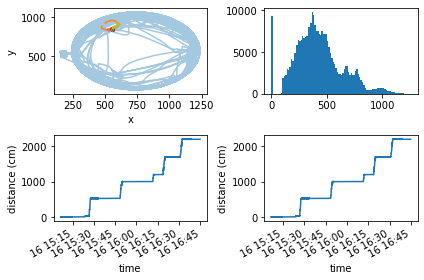

In [11]:
session = sessions.iloc[0]                                                    # pick a session
print('{0} on {1}...'.format(session.id, session.enter))                      # print session report
start = session.enter                                                         # session start time is session index
end = start + session.duration                                                # end time = start time + duration
position = aeon.load(root, exp02.CameraTop.Position, start=start, end=end)     # get position data between start and end
position = position[position.area < 2000]                                     # filter for objects of the correct size

encoder1 = aeon.load(root, exp02.Patch1.Encoder, start=start, end=end)        # get encoder data for patch1 between start and end
encoder2 = aeon.load(root, exp02.Patch2.Encoder, start=start, end=end)        # get encoder data for patch1 between start and end
pellets1 = aeon.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)  # get pellet events for patch1 between start and end
pellets2 = aeon.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)  # get pellet events for patch1 between start and end

wheel1 = distancetravelled(encoder1.angle)                                    # compute total distance travelled on patch1 wheel
wheel2 = distancetravelled(encoder2.angle)                                    # compute total distance travelled on patch2 wheel

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)                            # create a figure with subplots
ax1.plot(position.x, position.y, alpha=0.4)                                   # plot position data as a path trajectory
forage = position.reindex(pellets1.index, method='nearest')                   # get position data when a pellet is delivered at patch1
forage.plot.scatter('x','y',s=1,c='red',ax=ax1)                               # plot mouse positions when pellets were delivered

for trial in pellets1.itertuples():                                           # for each pellet delivery
    before = trial.Index - pd.to_timedelta(10, 's')                           # get the previous 10 seconds
    path = position.loc[before:trial.Index]                                   # get position data in the time before pellet delivery
    ax1.plot(path.x, path.y)                                                  # plot path traces preceding pellet delivery

ax2.hist(position.area, bins=100)                                             # plot histogram of tracked object size

wheel1.plot(ax=ax3)                                                           # plot distance travelled on patch1 wheel
wheel1.plot(ax=ax4)                                                           # plot distance travelled on patch2 wheel
ax3.set_ylabel('distance (cm)')                                               # set axis label
ax4.set_ylabel('distance (cm)')                                               # set axis label
fig.tight_layout()
plt.show()